Following  Danna's code found in /MNIST_anomaly/AE/Copy of AE_MNIST_Anomaly_1_8

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras import layers, losses
from keras.datasets import mnist
from keras.models import Model
import cv2

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [ ]:
(xf_train, yf_train), (xf_test, yf_test) = keras.datasets.fashion_mnist.load_data()
xf_train = xf_train.astype(np.float32) / 255
xf_test = xf_test.astype(np.float32) / 255

4431872/4422102 [==============================] - 0s 0us/step


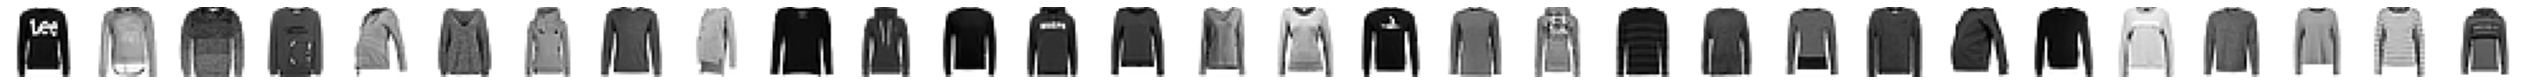

In [ ]:
#yf_test=2 is shirts <- this is our base, shoes will be the anomaly
#yf_test=9 is shoes

#note* yf_test=3 is dresses
#note* yf_test=8 is purses

nl = 2
abn = 9
normal_data = xf_test[(yf_test == nl)]
normal_labels = yf_test[(yf_test == nl)]

n_images = 30
fig = plt.figure(figsize=(n_images * 1.5, 3))
for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(normal_data[image_index])

In [ ]:
test_data = xf_test[(yf_test== abn) | (yf_test == nl)] # <- add the abnormal data (the shoes) to the shirt data
test_labels =  yf_test[(yf_test == abn) | (yf_test == nl)]

test_labels_T_F = np.where(test_labels == nl, True, False)

In [ ]:
print("shows us that the normal data has only shirts")
print(normal_labels[0:20])
print("\n")
print("shows us that we have normal and abnormal data")
print(test_labels[0:20])

shows us that the normal data has only shirts
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


shows us that we have normal and abnormal data
[9 2 2 2 9 9 9 2 2 2 2 2 2 9 2 2 2 9 2 2]


In [ ]:
normal_data = normal_data.astype('float32') / 255.
test_data = test_data.astype('float32') / 255.

In [ ]:
normal_test_data = test_data[test_labels == nl]
abnormal_test_data = test_data[test_labels == abn]

In [ ]:
normal_test_labels = test_labels[test_labels == nl]
abnormal_test_labels = test_labels[test_labels == abn]
normal_test_labels[0:20], abnormal_test_labels[0:20] # makeing sure the labels are separated correctly

(array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       dtype=uint8),
 array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
       dtype=uint8))

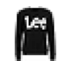

In [ ]:
# First shirt image
plt.figure(figsize=(1,1))
plt.imshow(normal_data[0], cmap="binary")
plt.axis('off')
plt.show()

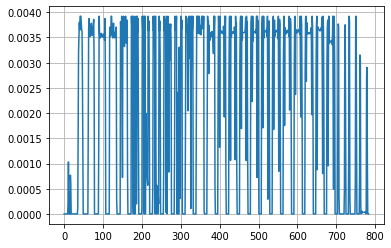

In [ ]:
# 1 dim plot of (flattened array of) first sihrt image
plt.grid()
plt.plot(np.arange(28*28), normal_data[0].ravel())
plt.show()

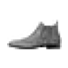

In [ ]:
# first test shirt (3/30/22 - i got a shoe as the first test)
plt.figure(figsize=(1,1))
plt.imshow(test_data[0], cmap="binary")
plt.axis('off')
plt.show()

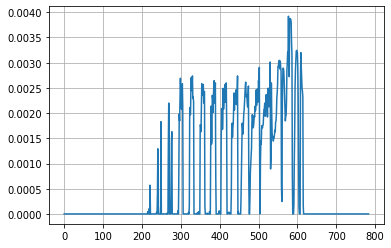

In [ ]:
# 1 dim plot of first test "shirt"
plt.grid()
plt.plot(np.arange(28*28), test_data[0].ravel())
plt.show()

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(128, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dense(28*28, activation="sigmoid"),
      layers.Reshape((28, 28))])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
history = autoencoder.fit(normal_data, normal_data, 
          epochs=100, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/100
2/2 [==============================] - 1s 255ms/step - loss: 0.4984 - val_loss: 0.4981
Epoch 2/100
2/2 [==============================] - 0s 69ms/step - loss: 0.4978 - val_loss: 0.4975
Epoch 3/100
2/2 [==============================] - 0s 68ms/step - loss: 0.4972 - val_loss: 0.4967
Epoch 4/100
2/2 [==============================] - 0s 71ms/step - loss: 0.4963 - val_loss: 0.4957
Epoch 5/100
2/2 [==============================] - 0s 84ms/step - loss: 0.4952 - val_loss: 0.4943
Epoch 6/100
2/2 [==============================] - 0s 75ms/step - loss: 0.4937 - val_loss: 0.4924
Epoch 7/100
2/2 [==============================] - 0s 73ms/step - loss: 0.4916 - val_loss: 0.4898
Epoch 8/100
2/2 [==============================] - 0s 67ms/step - loss: 0.4887 - val_loss: 0.4862
Epoch 9/100
2/2 [==============================] - 0s 77ms/step - loss: 0.4847 - val_loss: 0.4811
Epoch 10/100
2/2 [==============================] - 0s 78ms/step - loss: 0.4791 - val_loss: 0.4741
Epoch 11/100
2/2 [

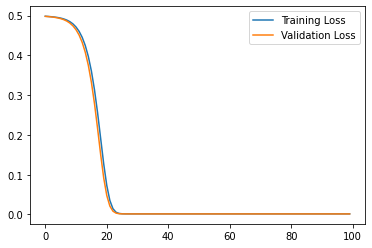

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

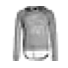

In [ ]:
plt.figure(figsize=(1,1))
plt.imshow(normal_test_data[1], cmap="binary")
plt.axis('off')
plt.show()

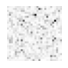

In [ ]:
plt.figure(figsize=(1,1))
plt.imshow(decoded_data[1], cmap="binary")
plt.axis('off')
plt.show()

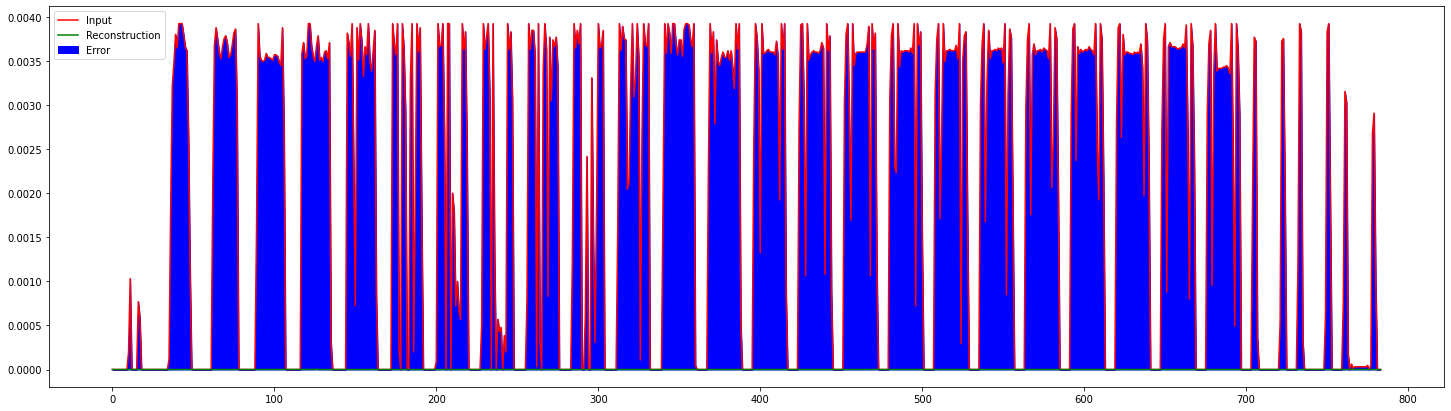

In [ ]:
plt.figure(figsize=(25,7))
plt.plot(normal_test_data[0].ravel(), 'r')
plt.plot(decoded_data[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), decoded_data[0].ravel(), normal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [ ]:
encoded_abn_data = autoencoder.encoder(abnormal_test_data).numpy()
decoded_abn_data = autoencoder.decoder(encoded_abn_data).numpy()

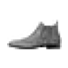

In [ ]:
plt.figure(figsize=(1,1))
plt.imshow(abnormal_test_data[0], cmap="binary")
plt.axis('off')
plt.show()

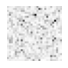

In [ ]:
plt.figure(figsize=(1,1))
plt.imshow(decoded_abn_data[0], cmap="binary")
plt.axis('off')
plt.show()

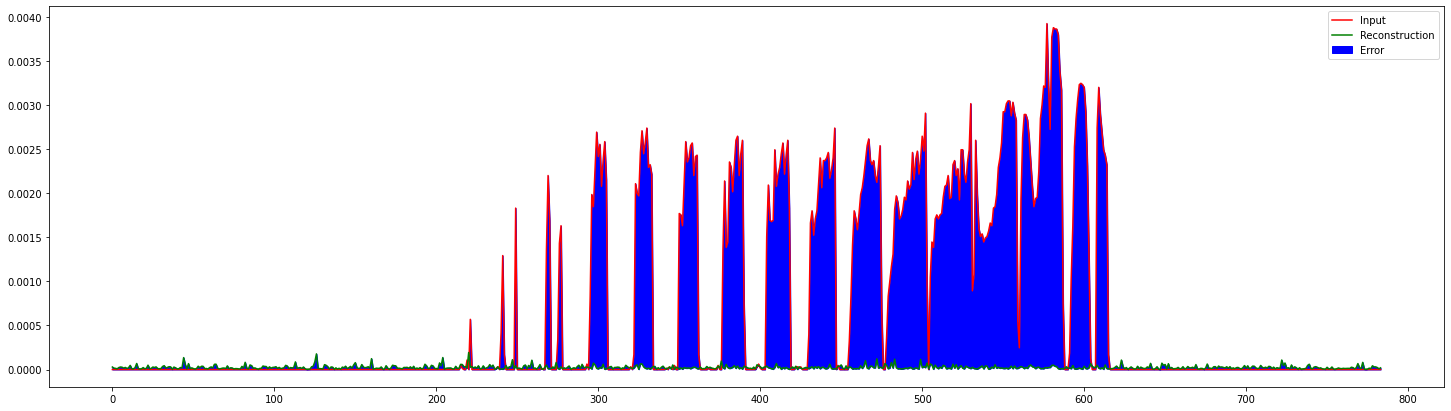

In [ ]:
plt.figure(figsize=(25,7))
plt.plot(abnormal_test_data[0].ravel(), 'r')
plt.plot(decoded_abn_data[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), decoded_abn_data[0].ravel(), abnormal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

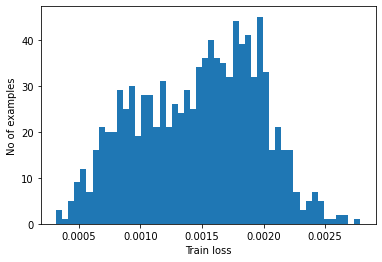

In [ ]:
reconstructions = autoencoder.predict(normal_data)
train_loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), normal_data.reshape(-1, 784))
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold) # really small threshold, there is not reconstruction with 100 epochs

Threshold:  0.0019562095


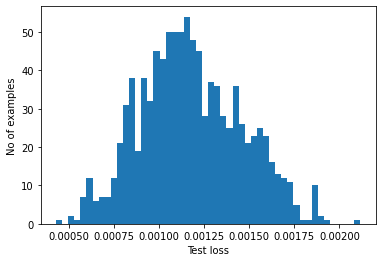

In [ ]:
reconstructions = autoencoder.predict(abnormal_test_data)
abn_test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), abnormal_test_data.reshape(-1,784))

plt.hist(abn_test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), data.reshape(-1, 784))
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  cf = confusion_matrix(labels, predictions)
  print("Confusion Matrix: \n prediction: F      T ")
  print("             {}   {}".format(preds[preds == False].shape[0], preds[preds == True].shape[0]))
  print(" label: F   [[{}   {}]    {}".format(cf[0,0], cf[0,1], test_labels_T_F[test_labels_T_F == False].shape[0]))
  print("        T    [{}   {}]]   {}".format(cf[1,0], cf[1,1], test_labels_T_F[test_labels_T_F == True].shape[0]))
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels_T_F)

Confusion Matrix: 
 prediction: F      T 
             177   1823
 label: F   [[1   999]    1000
        T    [176   824]]   1000
Accuracy = 0.4125
Precision = 0.45200219418540866
Recall = 0.824


In [ ]:
print(confusion_matrix(test_labels_T_F, preds)) # can see that the model did not learn at, there are many misses

[[  1 999]
 [176 824]]


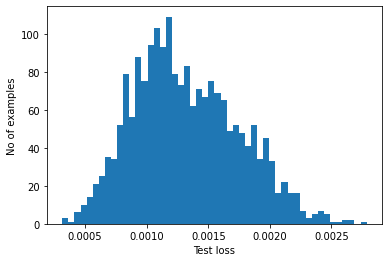

In [ ]:
reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), test_data.reshape(-1,784))

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()